In [22]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# import paired ttest
from scipy.stats import ttest_rel

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import homemade functions:
from MAPseq_processing import *
from MAPseq_plotting import *

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")
# omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")

# Preprocessing/sorting
## initial processing - OMC


# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

# seperate then concatenate by species
mm_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="MMus"]
st_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="STeg"]
mm_it_all = pd.concat(mm_it)
st_it_all = pd.concat(st_it)

mm_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="MMus"]
st_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="STeg"]
mm_pt_all = pd.concat(mm_pt)
st_pt_all = pd.concat(st_pt)


# IT Cells

In [24]:
plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)

it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [25]:
# plot paired dot plot

# isolate to singing mice
steg = it_motifs_df[it_motifs_df["species"]=="STeg"].reset_index(drop=True)

# calculate fold change (p_obs/p_calc)

# reform so that can use seaborn to plot
exp_steg_plot = steg.copy()
obs_steg_plot = steg.copy()
exp_steg_plot["proportion"] = steg["p_calc"]
obs_steg_plot["proportion"] = steg["p_obs"]
exp_steg_plot["compare"] = "expected"
obs_steg_plot["compare"] = "obeserved"

steg_plot = pd.concat([exp_steg_plot, obs_steg_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)

steg_plot



,motifs,n_shape,n_total,n_obs,mice,species,proportion,compare
0,OMCc_,535,555,64,STM1,STeg,0.110635,expected
1,AUD_,535,555,4,STM1,STeg,0.004604,expected
2,STR_,535,555,99,STM1,STeg,0.184259,expected
3,AUD_OMCc_,535,555,4,STM1,STeg,0.013914,expected
4,OMCc_STR_,535,555,310,STM1,STeg,0.556782,expected
...,...,...,...,...,...,...,...,...
93,STR_,527,530,29,STM7,STeg,0.054717,obeserved
94,AUD_OMCc_,527,530,9,STM7,STeg,0.016981,obeserved
95,OMCc_STR_,527,530,351,STM7,STeg,0.662264,obeserved
96,AUD_STR_,527,530,4,STM7,STeg,0.007547,obeserved


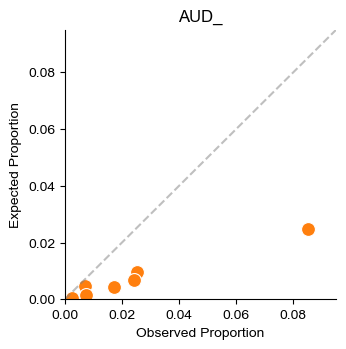

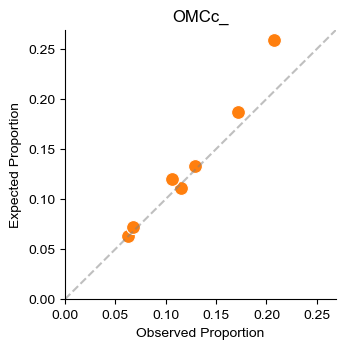

In [26]:
# single motif x/y plot

plot_motifs = ["AUD_", "OMCc_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = steg[steg["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:orange", s=100)
    plt.title(m)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plt.savefig(out_path+m+"_steg_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")

    plt.show()

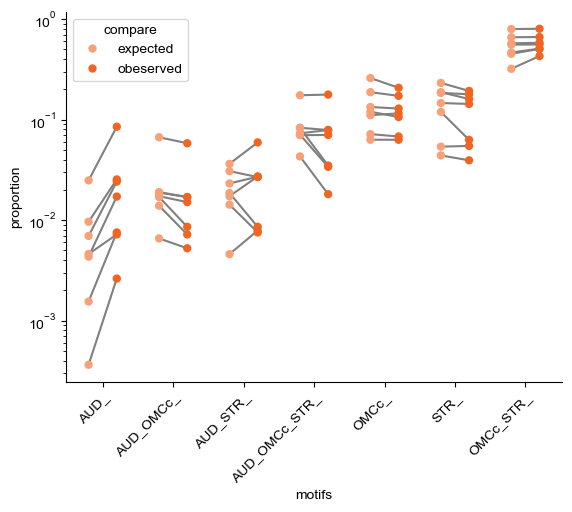

In [27]:
# plot

# set colors for plot
colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]
# set order of xaxis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                   dodge=.3, data=steg_plot, jitter=0, size=6, order=order)

for i in range(len(steg["motifs"].unique())):
    for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
        ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set yaxis on log
plt.yscale("log")

# get rid of top/side axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

plt.show()


In [28]:
# # set colors for plot
# colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]
# # set order of xaxis
# order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

# ax = sns.pointplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
#                    dodge=.3, data=steg_plot, order=order, ls="")

# # for i in range(len(motifs)):
# #     for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
# #         ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)

# # set yaxis on log
# plt.yscale("log")
# # rotate xaxis labels
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
# # get rid of top/side axis
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"_steg_avg_se.svg", dpi=300, bbox_inches="tight")

# plt.show()

In [29]:
# sns.scatterplot(steg, x="p_obs", y="p_calc", hue="motifs", style="mice")
# # plot on log scale
# plt.title("IT - Log scale")
# plt.xscale("log")
# plt.yscale("log")
# plt.axline((0,0), (0.6,0.6), color="red", linestyle="--", alpha=0.5)
# plt.legend(bbox_to_anchor=(1, 1))
# plt.xlabel("Observed proportion")
# plt.ylabel("Expected proportion")
# plt.savefig(out_path+"steg_motif_all_scatter.svg", dpi=300, bbox_inches="tight")
# plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_96967/3486898282.py:26: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')


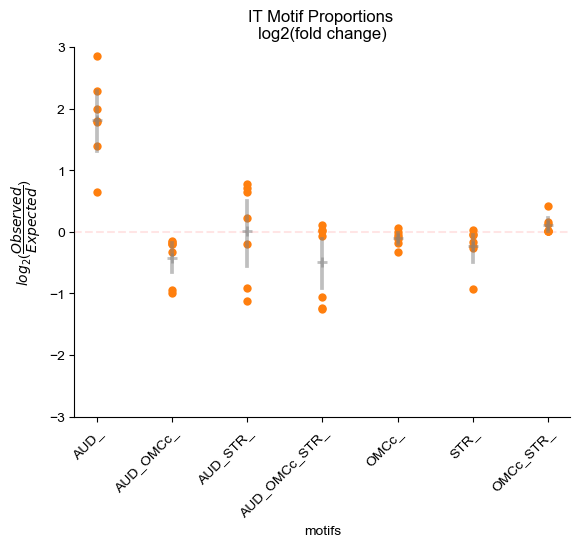

In [32]:
# match to steg expected (p_calc) mean?

# calculate fold change
# Calculate foldchange:
steg["fc"] = steg["p_obs"]/steg["p_calc"]
steg["log2fc"] = np.log2(steg["fc"])


sns.stripplot(x='motifs', y='log2fc', color="tab:orange",
                data=steg, jitter=0, size=6, order=order)
sns.pointplot(steg, x="motifs", y="log2fc", order=order, color="gray",
              alpha=0.5, ls="", zorder=10, marker="+")
plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-3,3)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

# plt.savefig(out_path+"steg_log2fc_motifs.svg", dpi=300, bbox_inches="tight")

plt.show()

In [134]:
# calcualte estimation confidence interval

# create df to save combinations
motif_strings = steg["motifs"].unique()
st_est_log2fc = pd.DataFrame(columns=motif_strings)

# cycle through all motifs
for m in motif_strings:
    st_m = steg[steg['motifs']== m]
    p_calc = st_m["p_calc"].reset_index(drop=True)
    st_m_est = pd.DataFrame(p_calc).rename(columns={"p_calc":"exp0"})
    for i in range(p_calc.shape[0]):
        shifted = p_calc.reindex(index=np.roll(p_calc.index, -i+1))
        st_m_est["exp"+str(i)] = shifted.values

    combos = pd.DataFrame(np.triu(st_m_est))
    combos.replace(0, np.nan, inplace=True)
    pairs = []
    for i in range(combos.shape[0]-1):
        pairs.append(combos.iloc[:,i]/combos.iloc[:,combos.shape[0]-1])
    fc = np.array(pairs).flatten()
    fc = fc[~np.isnan(fc)]
    log2fc = np.log2(fc)

    st_est_log2fc[m] = log2fc
st_est_log2fc


,OMCc_,AUD_,STR_,AUD_OMCc_,OMCc_STR_,AUD_STR_,AUD_OMCc_STR_
0,-1.852842,-4.001799,-1.148113,-1.812922,1.040764,-1.108193,1.080684
1,-1.227303,-2.431786,0.627636,-2.262240,0.797183,-0.407301,-0.237755
2,0.740917,2.636118,2.105400,-0.015118,-0.545835,1.349366,-1.301870
3,-1.111925,-1.365682,0.957287,-1.828040,0.494929,0.241172,-0.221186
4,1.385272,2.167766,1.799555,-0.134157,-0.502368,0.280126,-2.021796
5,0.270729,-0.086775,-0.334174,0.289632,0.042233,-0.315270,0.061137
6,-0.467570,-1.834033,0.651442,-1.947079,0.538397,-0.828067,-0.941112
7,0.896268,1.483238,1.441575,-0.159685,-0.201349,0.385622,-1.257302
8,-0.811157,-3.658984,-2.064841,-1.080437,0.513706,-2.334121,0.244426
9,1.111925,1.365682,-0.957287,1.828040,-0.494929,-0.241172,0.221186


In [150]:
st_aud

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,fc,log2fc
1,AUD_,535,555,4,0.007207,0.004604,STM1,STeg,1.565263,0.646405
8,AUD_,443,472,12,0.025424,0.009641,STM2,STeg,2.637121,1.398964
15,AUD_,306,331,8,0.024169,0.006968,STF3,STeg,3.468492,1.794309
22,AUD_,675,699,12,0.017167,0.004336,STF4,STeg,3.959554,1.985338
29,AUD_,380,381,1,0.002625,0.000365,STM5,STeg,7.200446,2.848086
36,AUD_,776,859,73,0.084983,0.024844,STF6,STeg,3.420656,1.774273
43,AUD_,527,530,4,0.007547,0.001551,STM7,STeg,4.866597,2.282913


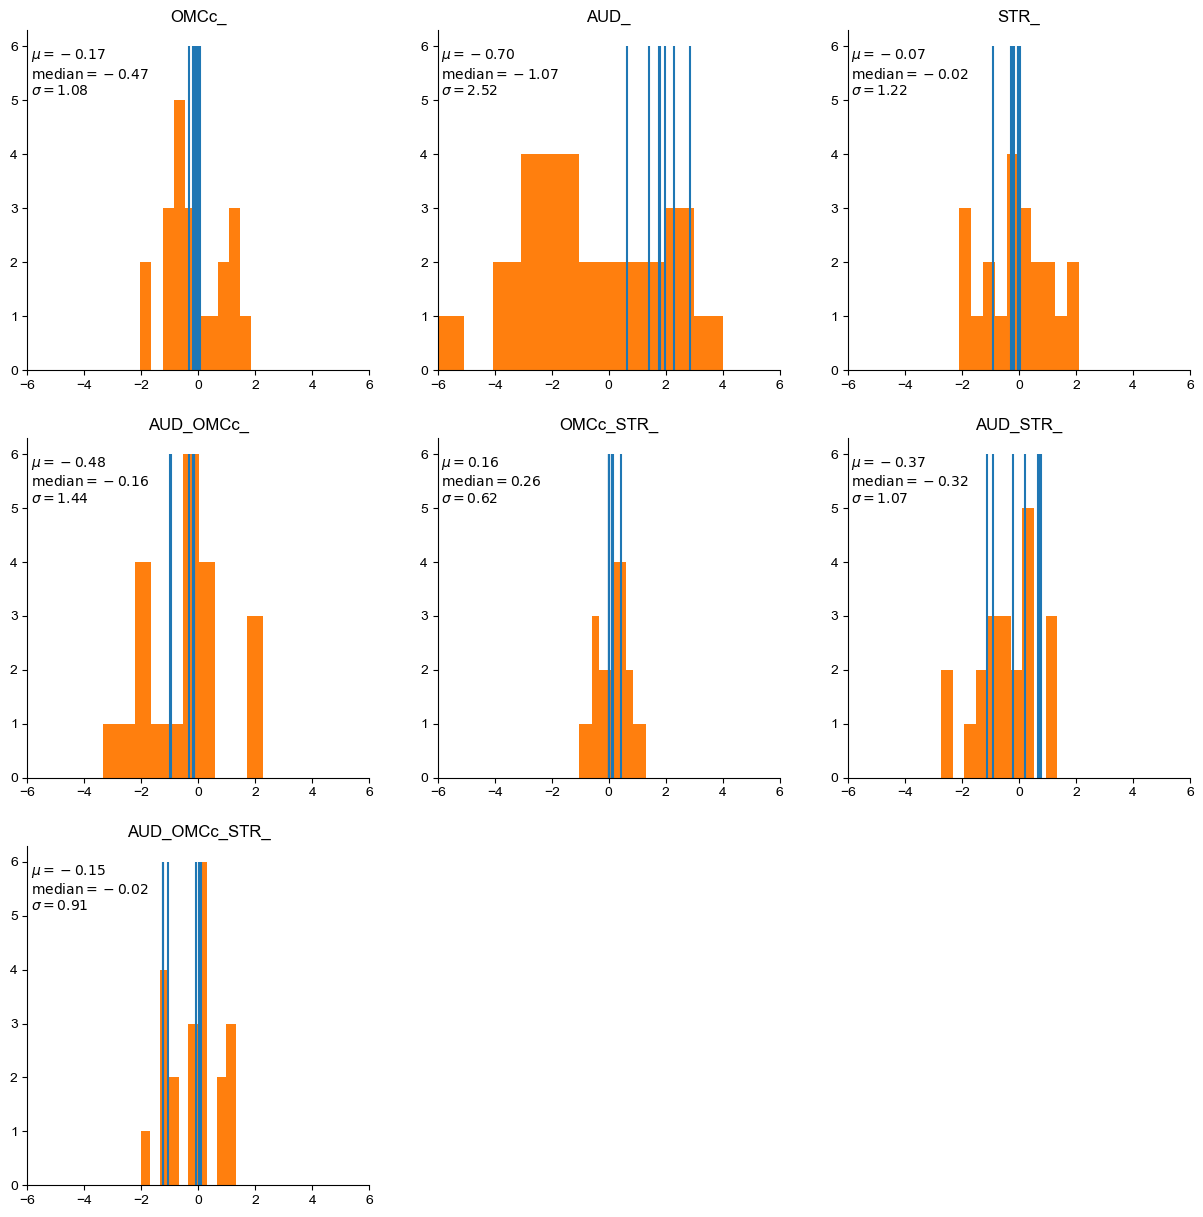

In [152]:
fig, axs = plt.subplots(3,3, figsize=(15,15))

i=0
for ax in axs.flat:
    if i >= len(motif_strings):
        ax.axis("off")
    else:
            
        motif = motif_strings[i]
        data = st_est_log2fc[motif]
        # plot histogram
        ax.hist(data, color="tab:orange")
        # add mu/sigma
        mu = data.mean()
        median = np.median(data)
        sigma = data.std()
        textstr = '\n'.join((
            r'$\mu=%.2f$' % (mu, ),
            r'$\mathrm{median}=%.2f$' % (median, ),
            r'$\sigma=%.2f$' % (sigma, )))

        # place a text box in upper left in axes coords
        ax.text(0.01, 0.95, textstr, transform = ax.transAxes,
                verticalalignment='top')
        ax.set_title(motif)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_xlim(-6,6)

        # plot p_obs values for each motif
        st_m = steg[steg["motifs"]==motif]
        ax.vlines(st_m["log2fc"], ymin=0, ymax=6)
    i+=1

plt.show()

## mmus

In [17]:
# plot paired dot plot
plot_areas = ["OMCc", "AUD", "STR"]


# isolate to singing mice
mmus = it_motifs_df[it_motifs_df["species"]=="MMus"].reset_index(drop=True)

# reform so that can use seaborn to plot
exp_mmus_plot = mmus.copy()
obs_mmus_plot = mmus.copy()
exp_mmus_plot["proportion"] = mmus["p_calc"]
obs_mmus_plot["proportion"] = mmus["p_obs"]
exp_mmus_plot["compare"] = "expected"
obs_mmus_plot["compare"] = "obeserved"

mmus_plot = pd.concat([exp_mmus_plot, obs_mmus_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)



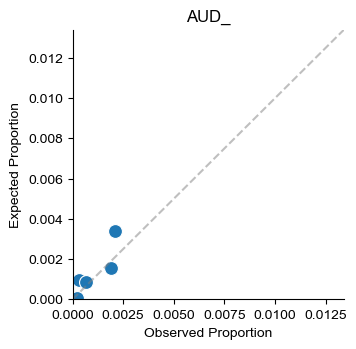

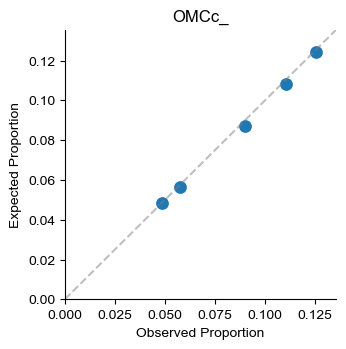

In [18]:
# single morif x/y plot

plot_motifs = ["AUD_", "OMCc_"]


for m in plot_motifs:
    fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))

    plot_df = mmus[mmus["motifs"]==m]


    sns.scatterplot(plot_df, x="p_obs", y="p_calc", color="tab:blue", s=100)
    plt.title(m)

    # draw x=y line
    plt.axline((0,0), (0.02, 0.02), color="gray", linestyle="--", alpha=0.5)

    # get max to get bounds to plot
    max = pd.concat([plot_df["p_calc"], plot_df["p_obs"]]).max()
    plt.xlim(0,max+0.01)
    plt.ylim(0,max+0.01)

    plt.xlabel("Observed Proportion")
    plt.ylabel("Expected Proportion")

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(out_path+m+"mmus_obs_exp_scatter.svg", dpi=300, bbox_inches="tight")
    

    plt.show()


In [16]:

# plot

# set colors for plot
colors = [blue_cmp.colors[-100], blue_cmp.colors[-1]]
# set order of xaxis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                   dodge=.3, data=mmus_plot, jitter=0, size=6, order=order)

for i in range(len(mmus["motifs"].unique())):
    for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
        ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set yaxis on log
plt.yscale("log")

# get rid of top/side axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(out_path+"mmus_paired.svg", dpi=300, bbox_inches="tight")

plt.show()


NameError: name 'mmus_plot' is not defined

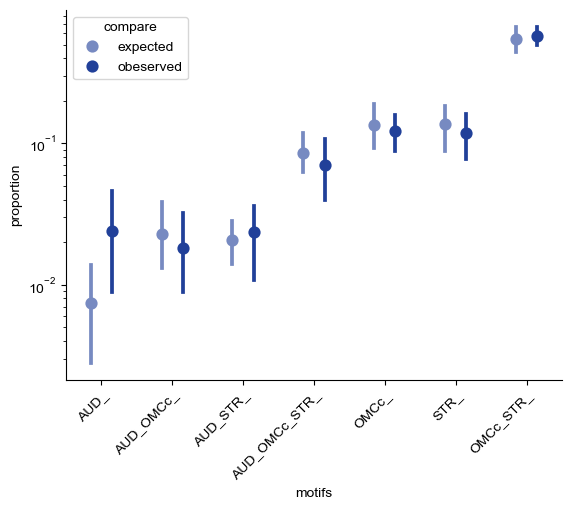

In [31]:

# set colors for plot
colors = [blue_cmp.colors[-100], blue_cmp.colors[-1]]
# set order of xaxis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]


ax = sns.pointplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                   dodge=.3, data=mmus_plot, order=order, ls="")

# for i in range(len(motifs)):
#     for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
#         ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)

# set yaxis on log
plt.yscale("log")
# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
# get rid of top/side axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(out_path+"mmus_avg_se.svg", dpi=300, bbox_inches="tight")


plt.show()



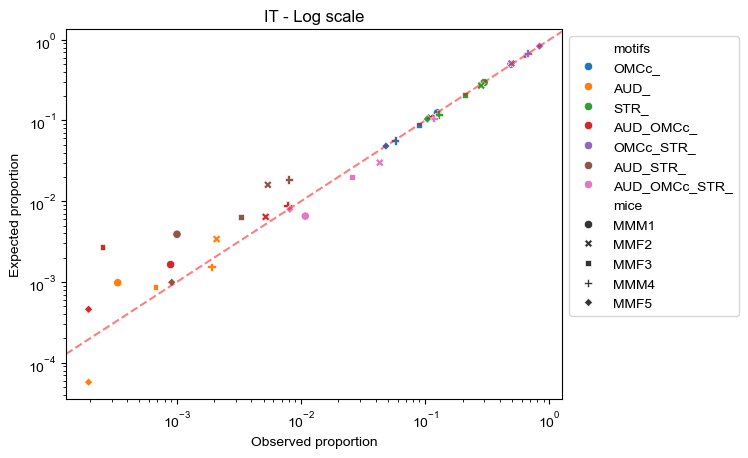

In [189]:

sns.scatterplot(mmus, x="p_obs", y="p_calc", hue="motifs", style="mice")
# plot on log scale
plt.title("IT - Log scale")
plt.xscale("log")
plt.yscale("log")
plt.axline((0,0), (0.6,0.6), color="red", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Observed proportion")
plt.ylabel("Expected proportion")
plt.savefig(out_path+"mmus_motif_scatter.svg", dpi=300, bbox_inches="tight")

plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_96967/893476679.py:22: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')


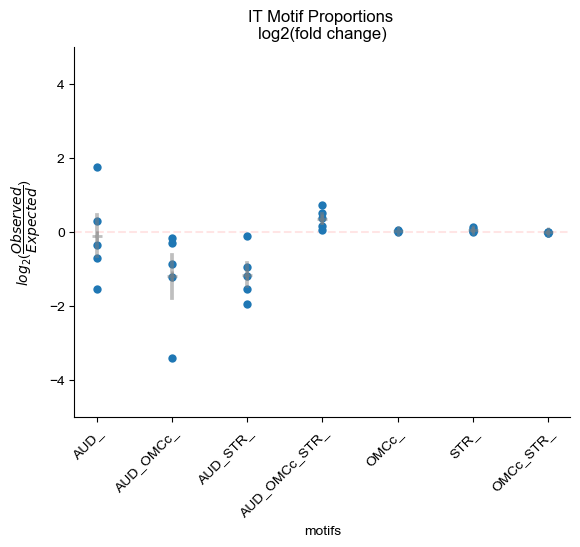

In [21]:

# Calculate foldchange:
mmus["fc"] = mmus["p_obs"]/mmus["p_calc"]
mmus["log2fc"] = np.log2(mmus["fc"])

sns.stripplot(x='motifs', y='log2fc', color="tab:blue",
                data=mmus, jitter=0, size=6, order=order)
sns.pointplot(mmus, x="motifs", y="log2fc", order=order, color="gray",
              alpha=0.5, ls="", zorder=10, marker="+", errorbar="se")
plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-5,5)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

plt.savefig(out_path+"mmus_it_log2fc.svg", dpi=300, bbox_inches="tight")
plt.show()

## plot mmus w/ steg:


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_85248/3827856774.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_85248/3827856774.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.pointplot(fc_plot, x="motifs", y="log2fc", hue="species", color="gray", alpha=0.3,


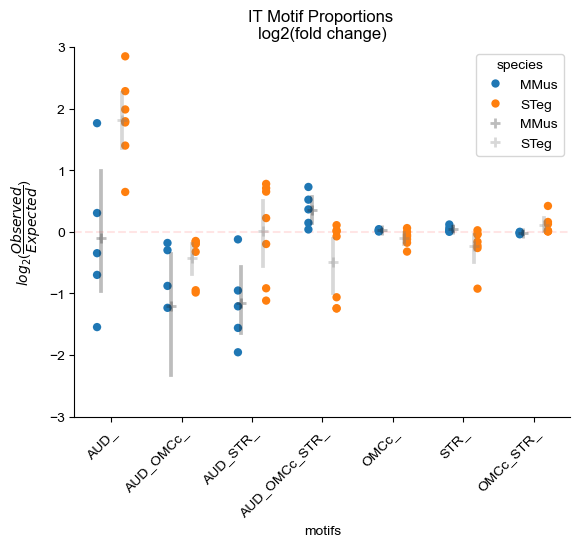

In [191]:
fc_plot = pd.concat([mmus, steg])

sns.stripplot(x='motifs', y='log2fc', hue='species',
                   dodge=0.3, data=fc_plot, jitter=0, size=6, order=order)
sns.pointplot(fc_plot, x="motifs", y="log2fc", hue="species", color="gray", alpha=0.3,
              dodge=0.3, marker="+", order=order, ls="", zorder=10)

plt.axline((0,0), (1,0), color="red", ls="--", alpha=0.1)

# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# set limits to equal
plt.ylim(-3,3)

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('$log_{2}$($\dfrac{Observed}{Expected}$)')

plt.title("IT Motif Proportions \nlog2(fold change)")

plt.savefig(out_path+"mmus_steg_it_log2fc.svg", dpi=300, bbox_inches="tight")


plt.show()

# PT cells

In [3]:
plot_areas = ["HY", "AMY", "SNr", "SCm", "PG", "PAG", "BS"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_pt[i], plot_areas) for i in range(len(omc_pt))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_pt]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_pt]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
pt_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_pt[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    pt_motifs_df.append(df)
pt_motifs_df = pd.concat(pt_motifs_df).reset_index(drop=True)

pt_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,HY_,1313,1325,168,0.126792,0.055741,MMM1,MMus
1,AMY_,1313,1325,3,0.002264,0.000790,MMM1,MMus
2,SNr_,1313,1325,18,0.013585,0.009012,MMM1,MMus
3,SCm_,1313,1325,13,0.009811,0.002553,MMM1,MMus
4,PG_,1313,1325,85,0.064151,0.030364,MMM1,MMus
...,...,...,...,...,...,...,...,...
1519,AMY_BS_HY_PAG_PG_SNr_,216,217,14,0.064516,0.011282,STM7,STeg
1520,AMY_BS_HY_PAG_PG_SCm_,216,217,2,0.009217,0.004538,STM7,STeg
1521,BS_HY_PAG_PG_SCm_SNr_,216,217,1,0.004608,0.003356,STM7,STeg
1522,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,0.046083,0.021805,STM7,STeg


In [4]:
# Get ranked list of pt motifs for each mouse

for mouse in metadata["mice"]:

    # create ranked list for each mouse
    mouse_df = pt_motifs_df[pt_motifs_df["mice"]==mouse]
    mouse_sort = mouse_df.sort_values(by=["p_obs"], ascending=False)
    rank = 1 # start ranking at 1
    for idx, row in mouse_sort.iterrows():
        pt_motifs_df.loc[idx, "rank"] = rank
        # only increase rank if p_obs more than 0
        if row["p_obs"] > 0:
            rank+=1

pt_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,rank
0,HY_,1313,1325,168,0.126792,0.055741,MMM1,MMus,3.0
1,AMY_,1313,1325,3,0.002264,0.000790,MMM1,MMus,38.0
2,SNr_,1313,1325,18,0.013585,0.009012,MMM1,MMus,12.0
3,SCm_,1313,1325,13,0.009811,0.002553,MMM1,MMus,16.0
4,PG_,1313,1325,85,0.064151,0.030364,MMM1,MMus,6.0
...,...,...,...,...,...,...,...,...,...
1519,AMY_BS_HY_PAG_PG_SNr_,216,217,14,0.064516,0.011282,STM7,STeg,3.0
1520,AMY_BS_HY_PAG_PG_SCm_,216,217,2,0.009217,0.004538,STM7,STeg,21.0
1521,BS_HY_PAG_PG_SCm_SNr_,216,217,1,0.004608,0.003356,STM7,STeg,45.0
1522,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,0.046083,0.021805,STM7,STeg,6.0


/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series

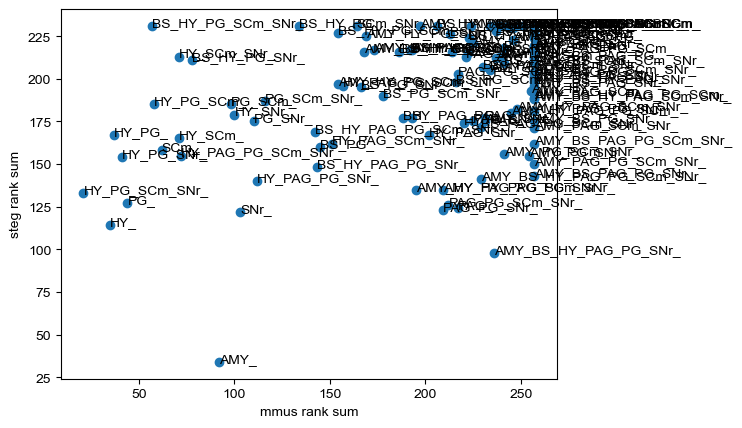

In [5]:
species_rank_sum = pt_motifs_df.groupby(["species", "motifs"]).sum().reset_index()
x = species_rank_sum[species_rank_sum["species"]=="MMus"]
y = species_rank_sum[species_rank_sum["species"]=="STeg"]
plt.scatter(x["rank"],y["rank"] )
for m in species_rank_sum["motifs"].unique():
    xpoint = x[x["motifs"]==m]
    ypoint = y[y["motifs"]==m]
    plt.text(xpoint["rank"], ypoint["rank"], m)

plt.xlabel("mmus rank sum")
plt.ylabel("steg rank sum")
plt.show()

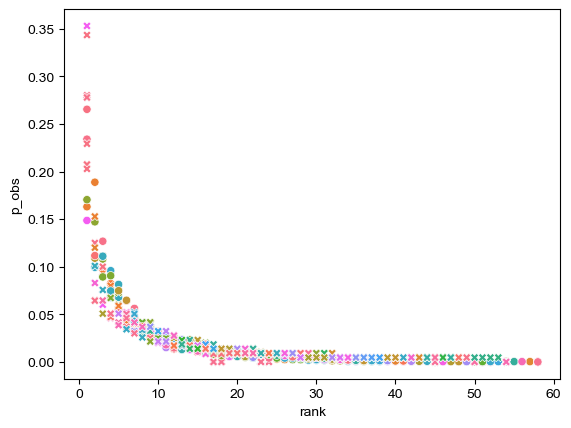

In [6]:
sns.scatterplot(pt_motifs_df, x="rank", y="p_obs", hue="motifs", style="species")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend([],[], frameon=False)

plt.show()


In [7]:
# for m in metadata["mice"]:
#     mouse = rank20[rank20["mice"]==m]
#     print(mouse.sort_values(by="rank"))
rank20 = pt_motifs_df[pt_motifs_df["rank"]<=20]
rank20['motifs'].value_counts()

motifs
HY_                    10
AMY_                   10
PG_                    10
HY_PG_SCm_SNr_          9
SCm_                    9
                       ..
BS_                     2
AMY_BS_HY_PAG_SCm_      2
AMY_BS_HY_PAG_PG_       2
AMY_BS_PG_SCm_SNr_      2
AMY_BS_PAG_SCm_SNr_     2
Name: count, Length: 127, dtype: int64

In [8]:
steg_rank20 = rank20[rank20["species"]=="STeg"]
mmus_rank20 = rank20[rank20["species"]=="MMus"]

print(steg_rank20["motifs"].value_counts())
print(mmus_rank20["motifs"].value_counts())


motifs
AMY_                     7
SNr_                     6
HY_                      5
PG_                      5
AMY_BS_HY_PAG_PG_SNr_    5
                        ..
AMY_PG_SCm_              2
AMY_BS_SCm_              2
AMY_PAG_PG_              2
AMY_BS_PG_               2
AMY_BS_PAG_              2
Name: count, Length: 127, dtype: int64
motifs
HY_                       5
SCm_                      5
PG_                       5
HY_SCm_SNr_               5
HY_PG_                    5
BS_HY_PG_SCm_SNr_         5
HY_PG_SCm_SNr_            5
HY_PG_SNr_                5
HY_SCm_                   4
HY_PG_SCm_                4
HY_PAG_PG_SCm_SNr_        4
HY_SNr_                   3
SNr_                      3
AMY_                      3
BS_HY_PG_SNr_             3
PG_SCm_SNr_               3
PG_SNr_                   3
BS_HY_PAG_PG_SCm_SNr_     3
AMY_BS_HY_PG_SCm_SNr_     2
AMY_HY_PG_SCm_SNr_        2
BS_HY_PG_                 2
BS_HY_PAG_PG_SNr_         2
HY_PAG_PG_SNr_            2
AMY_HY

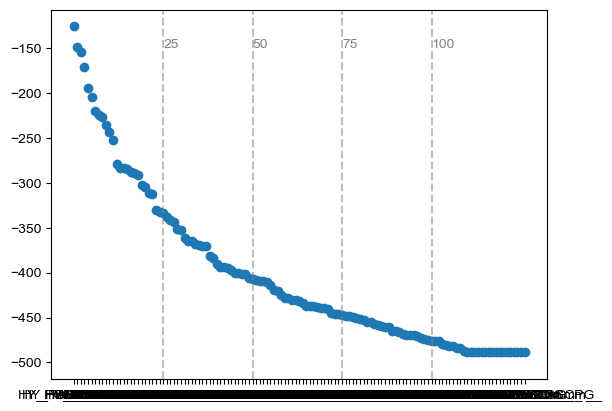

In [9]:
rank_sum = pt_motifs_df.groupby("motifs").sum()["rank"]
rank_sort = rank_sum.sort_values()
plt.scatter(rank_sort.index, -rank_sort)

plt.axline((25,-500), (25,-250), color="gray", ls="--", alpha=0.5 )
plt.text(25,-150, "25", color="gray")

plt.axline((50,-500), (50,-250), color="gray", ls="--", alpha=0.5 )
plt.text(50,-150, "50", color="gray")

plt.axline((75,-500), (75,-250), color="gray", ls="--", alpha=0.5 )
plt.text(75,-150, "75", color="gray")

plt.axline((100,-500), (100,-250), color="gray", ls="--", alpha=0.5 )
plt.text(100,-150, "100", color="gray")

plt.show()

In [11]:
# look at motifs 10 at a time
steg_pt_motifs = pt_motifs_df[pt_motifs_df["species"]=="STeg"]

# make plottable df
# plot paired dot plot
plot_areas = ['HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']


# isolate to singing mice
steg = pt_motifs_df[pt_motifs_df["species"]=="STeg"].reset_index(drop=True)

# reform so that can use seaborn to plot
exp_steg_plot = steg.copy()
obs_steg_plot = steg.copy()
exp_steg_plot["proportion"] = steg["p_calc"]
obs_steg_plot["proportion"] = steg["p_obs"]
exp_steg_plot["compare"] = "expected"
obs_steg_plot["compare"] = "obeserved"

steg_plot = pd.concat([exp_steg_plot, obs_steg_plot]).drop(columns=["p_obs", "p_calc"]).reset_index(drop=True)
steg_plot

,motifs,n_shape,n_total,n_obs,mice,species,rank,proportion,compare
0,HY_,93,96,12,STM1,STeg,2.0,0.072760,expected
1,AMY_,93,96,22,STM1,STeg,1.0,0.013618,expected
2,SNr_,93,96,1,STM1,STeg,15.0,0.040190,expected
3,SCm_,93,96,1,STM1,STeg,16.0,0.001997,expected
4,PG_,93,96,0,STM1,STeg,24.0,0.016430,expected
...,...,...,...,...,...,...,...,...,...
1773,AMY_BS_HY_PAG_PG_SNr_,216,217,14,STM7,STeg,3.0,0.064516,obeserved
1774,AMY_BS_HY_PAG_PG_SCm_,216,217,2,STM7,STeg,21.0,0.009217,obeserved
1775,BS_HY_PAG_PG_SCm_SNr_,216,217,1,STM7,STeg,45.0,0.004608,obeserved
1776,AMY_BS_PAG_PG_SCm_SNr_,216,217,10,STM7,STeg,6.0,0.046083,obeserved


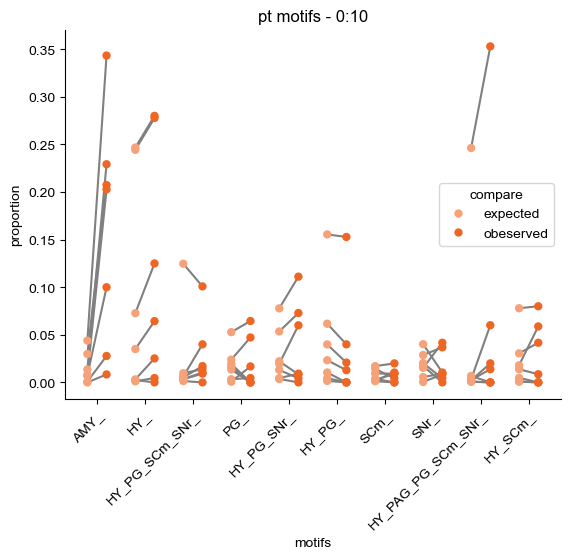

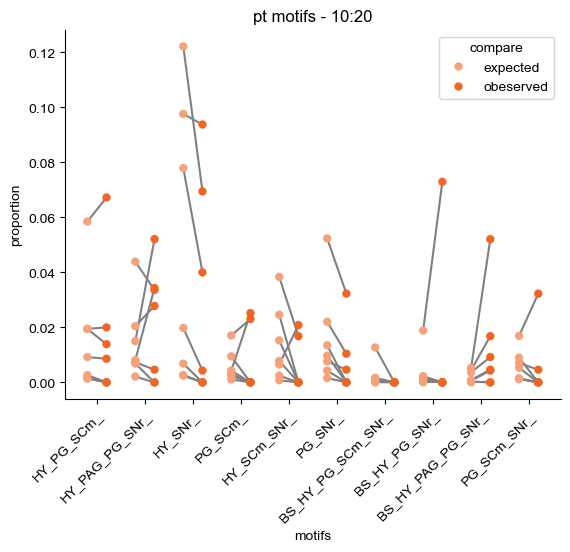

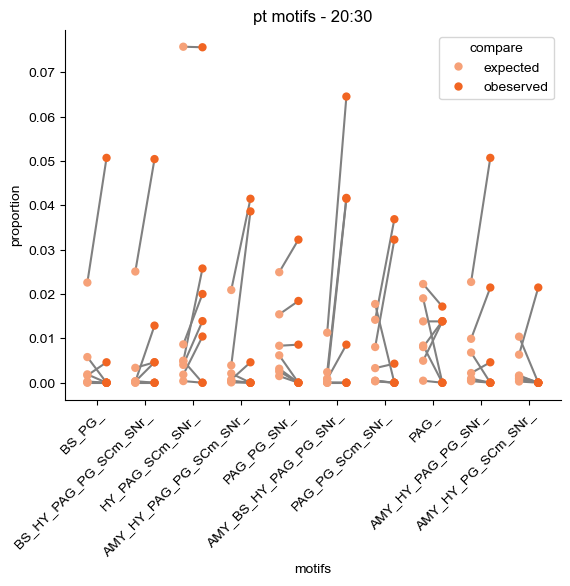

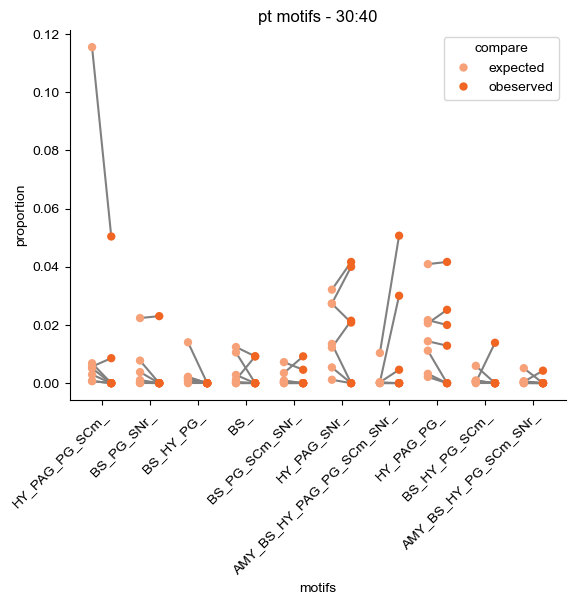

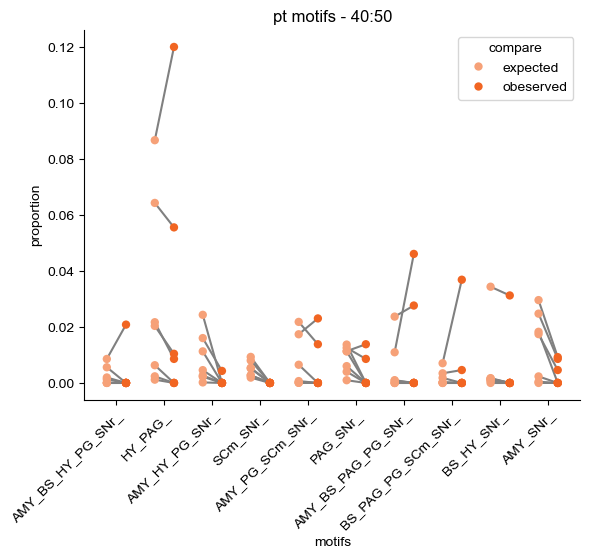

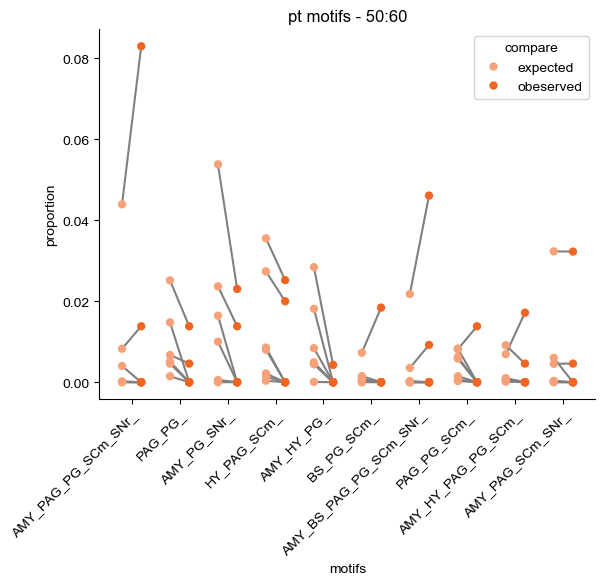

In [12]:


# set colors for plot
colors = [orange_cmp.colors[-100], orange_cmp.colors[-1]]


# make plots for every 10 motifs for top 50 motifs
for r in range(6):
    # set order of xaxis
    order = rank_idx[r*10:r*10+10]["motifs"]
    # only keep motifs to plot
    plot_df = steg_plot[steg_plot["motifs"].isin(order)].reset_index(drop=True)

    ax = sns.stripplot(x='motifs', y='proportion', hue='compare', palette=[colors[0], colors[1]],
                    dodge=.3, data=plot_df, jitter=0, size=6, order=order)

    for i in range(10):
        for (x0, y0), (x1, y1) in zip(ax.collections[2*i].get_offsets(), ax.collections[2*i+1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='grey', zorder=0)
    # rotate xaxis labels
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set yaxis on log
    # plt.yscale("log")

    # get rid of top/side axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title("pt motifs - "+str(r*10)+":"+str(r*10+10))

    # plt.savefig(out_path+"_steg_individ_paired.svg", dpi=300, bbox_inches="tight")

    plt.show()


## calculate cut-offs?
<img src="neuron_estimate.png">


In [15]:
# use 36 as cutoff

# filter out motifs that are observed <36 times
pt_cutoff = pt_motifs_df[pt_motifs_df["n_obs"]>=36]
pt_cutoff[pt_cutoff["species"]=="STeg"]

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species,rank
1017,AMY_,211,217,45,0.207373,0.029863,STF4,STeg,1.0
1251,HY_PAG_PG_SCm_SNr_,119,119,42,0.352941,0.246193,STM5,STeg,1.0
1271,AMY_,225,233,80,0.343348,0.043898,STF6,STeg,1.0
1398,AMY_,216,217,44,0.202765,0.007622,STM7,STeg,1.0
